In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, random_split
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from sklearn.metrics import accuracy_score
from torchvision import datasets, transforms
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import RandomSampler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

In [2]:
# Data augmentation functions
def rotate_point_cloud(points):
    """Rotate the point cloud around the z-axis."""
    angle = np.random.uniform(0, 2 * np.pi)
    cos_val = np.cos(angle)
    sin_val = np.sin(angle)
    rotation_matrix = np.array([
        [cos_val, -sin_val, 0],
        [sin_val, cos_val, 0],
        [0, 0, 1]
    ])
    rotated_points = np.dot(points, rotation_matrix.T)
    return rotated_points

def translate_point_cloud(points):
    """Translate the point cloud by a small random vector."""
    translation_vector = np.random.uniform(-0.2, 0.2, size=(1, 3))
    translated_points = points + translation_vector
    return translated_points

def scale_point_cloud(points):
    """Scale the point cloud by a random factor."""
    scale_factor = np.random.uniform(0.8, 1.2)
    scaled_points = points * scale_factor
    return scaled_points

def jitter_point_cloud(points):
    """Add Gaussian noise to the point cloud."""
    noise = np.random.normal(0, 0.01, points.shape)
    jittered_points = points + noise
    return jittered_points

def augment_point_cloud(points):
    points = rotate_point_cloud(points)
    points = translate_point_cloud(points)
    points = scale_point_cloud(points)
    points = jitter_point_cloud(points)
    return points

def normalize_point_cloud(points):
    """Normalize the point cloud."""
    centroid = np.mean(points, axis=0)
    points -= centroid
    max_dist = np.max(np.sqrt(np.sum(points**2, axis=1)))
    points /= max_dist
    return points


In [14]:



class PointCloudDataset(Dataset):
    def __init__(self, data_dir, augment=True):
        self.data_dir = data_dir
        self.files = [f for f in os.listdir(data_dir) if f.endswith('.npy')]
        self.augment = augment

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = os.path.join(self.data_dir, self.files[idx])
        data = np.load(file_path)
        points = data[:, :3]  
        labels = data[:, 3]   
        
        #if self.augment:
        points = augment_point_cloud(points)
            
        
        points = normalize_point_cloud(points)
        
        
        points = torch.FloatTensor(points)
        labels = torch.FloatTensor(labels)  # Convert labels to float for BCELoss
        
        return points, labels



def collate_fn(batch):
 
    max_points = min(1024, max(item[0].size(0) for item in batch))  # Limit to 1024 points

    padded_points = []
    padded_labels = []

    for points, labels in batch:
        
        if points.size(0) > max_points:
            points = points[:max_points]
            labels = labels[:max_points]
        
        
        pad_size = max_points - points.size(0)
        
   
        padded = torch.nn.functional.pad(points, (0, 0, 0, pad_size)) 
        padded_points.append(padded)
        

        padded_label = torch.cat((labels, torch.zeros(pad_size)))
        padded_labels.append(padded_label)


    return torch.stack(padded_points), torch.stack(padded_labels)

In [15]:
import torch
import torch.nn as nn

class PointNetPlusPlus(nn.Module):
    def __init__(self):
        super(PointNetPlusPlus, self).__init__()

        # First MLP block with dropout
        self.mlp1 = nn.Sequential(
            nn.Linear(3, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        self.bn1 = nn.BatchNorm1d(512)  

       
        self.residual1 = nn.Linear(3, 512) 

       
        self.abstraction = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )

        self.mlp2 = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  
        )

       
        self.residual2 = nn.Linear(128, 1) 

        self.mlp3 = nn.Sequential(
            nn.Linear(1, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1) 
        )
        
       
        self.residual3 = nn.Linear(1, 1)  

    def forward(self, x):
        # Apply the first MLP
        identity1 = self.residual1(x)
        x = self.mlp1(x)
        x = x + identity1

        # Apply the second MLP with residual connection
        x = self.abstraction(x)
        identity2 = self.residual2(x)
        x = self.mlp2(x)
        x = x + identity2

        # Apply the third MLP with residual connection
        identity3 = self.residual3(x)
        x = self.mlp3(x)
        x = x + identity3

        # Final output
        return x.squeeze(-1) 


In [16]:
import zipfile
import os

# Define the path to your zip file and the extraction directory
zip_file_path = '/home/jovyan/RnD/dataset_npy.zip'
extract_dir = '/home/jovyan/RnD/dataset_npy'  # Folder where data will be extracted

# Check if the extraction directory exists, if not, create it
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Extracted data to {extract_dir}")

Extracted data to /home/jovyan/RnD/dataset_npy


Epoch 1/64


Training:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.6171, Val Loss: 0.6045, Val Accuracy: 0.7494
Saved the best model!
Epoch 2/64


Train Loss: 0.6026, Val Loss: 0.5932, Val Accuracy: 0.7494
Saved the best model!
Epoch 3/64


Train Loss: 0.5909, Val Loss: 0.5839, Val Accuracy: 0.7494
Saved the best model!
Epoch 4/64


Train Loss: 0.5811, Val Loss: 0.5755, Val Accuracy: 0.7494
Saved the best model!
Epoch 5/64


Train Loss: 0.5724, Val Loss: 0.5689, Val Accuracy: 0.7494
Saved the best model!
Epoch 6/64


Train Loss: 0.5660, Val Loss: 0.5638, Val Accuracy: 0.7494
Saved the best model!
Epoch 7/64


Train Loss: 0.5620, Val Loss: 0.5610, Val Accuracy: 0.7494
Saved the best model!
Epoch 8/64


Train Loss: 0.5614, Val Loss: 0.5588, Val Accuracy: 0.7494
Saved the best model!
Epoch 9/64


Train Loss: 0.5599, Val Loss: 0.5589, Val Accuracy: 0.7494
Epoch 10/64


Train Loss: 0.5601, Val Loss: 0.5580, Val Accuracy: 0.7494
Saved the best model!
Epoch 11/64


Train Loss: 0.5593, Val Loss: 0.5557, Val Accuracy: 0.7494
Saved the best model!
Epoch 12/64


Train Loss: 0.5559, Val Loss: 0.5557, Val Accuracy: 0.7494
Saved the best model!
Epoch 13/64


Train Loss: 0.5552, Val Loss: 0.5539, Val Accuracy: 0.7494
Saved the best model!
Epoch 14/64


Train Loss: 0.5535, Val Loss: 0.5514, Val Accuracy: 0.7494
Saved the best model!
Epoch 15/64


Train Loss: 0.5513, Val Loss: 0.5499, Val Accuracy: 0.7494
Saved the best model!
Epoch 16/64


Train Loss: 0.5498, Val Loss: 0.5468, Val Accuracy: 0.7494
Saved the best model!
Epoch 17/64


Train Loss: 0.5468, Val Loss: 0.5447, Val Accuracy: 0.7494
Saved the best model!
Epoch 18/64


Train Loss: 0.5441, Val Loss: 0.5409, Val Accuracy: 0.7494
Saved the best model!
Epoch 19/64


Train Loss: 0.5416, Val Loss: 0.5375, Val Accuracy: 0.7494
Saved the best model!
Epoch 20/64


Train Loss: 0.5377, Val Loss: 0.5328, Val Accuracy: 0.7494
Saved the best model!
Epoch 21/64


Train Loss: 0.5335, Val Loss: 0.5297, Val Accuracy: 0.7494
Saved the best model!
Epoch 22/64


Train Loss: 0.5294, Val Loss: 0.5241, Val Accuracy: 0.7494
Saved the best model!
Epoch 23/64


Train Loss: 0.5262, Val Loss: 0.5217, Val Accuracy: 0.7494
Saved the best model!
Epoch 24/64


Train Loss: 0.5227, Val Loss: 0.5165, Val Accuracy: 0.7494
Saved the best model!
Epoch 25/64


Train Loss: 0.5201, Val Loss: 0.5114, Val Accuracy: 0.7494
Saved the best model!
Epoch 26/64


Train Loss: 0.5118, Val Loss: 0.5046, Val Accuracy: 0.7494
Saved the best model!
Epoch 27/64


Train Loss: 0.5084, Val Loss: 0.4995, Val Accuracy: 0.7494
Saved the best model!
Epoch 28/64


Train Loss: 0.5021, Val Loss: 0.4916, Val Accuracy: 0.7494
Saved the best model!
Epoch 29/64


Train Loss: 0.4956, Val Loss: 0.4875, Val Accuracy: 0.7496
Saved the best model!
Epoch 30/64


Train Loss: 0.4906, Val Loss: 0.4811, Val Accuracy: 0.7506
Saved the best model!
Epoch 31/64


Train Loss: 0.4861, Val Loss: 0.4743, Val Accuracy: 0.7513
Saved the best model!
Epoch 32/64


Train Loss: 0.4807, Val Loss: 0.4702, Val Accuracy: 0.7531
Saved the best model!
Epoch 33/64


Train Loss: 0.4757, Val Loss: 0.4681, Val Accuracy: 0.7579
Saved the best model!
Epoch 34/64


Train Loss: 0.4694, Val Loss: 0.4626, Val Accuracy: 0.7639
Saved the best model!
Epoch 35/64


Train Loss: 0.4661, Val Loss: 0.4589, Val Accuracy: 0.7743
Saved the best model!
Epoch 36/64


Train Loss: 0.4625, Val Loss: 0.4582, Val Accuracy: 0.7798
Saved the best model!
Epoch 37/64


Train Loss: 0.4620, Val Loss: 0.4531, Val Accuracy: 0.7869
Saved the best model!
Epoch 38/64


Train Loss: 0.4568, Val Loss: 0.4481, Val Accuracy: 0.7959
Saved the best model!
Epoch 39/64


Train Loss: 0.4522, Val Loss: 0.4459, Val Accuracy: 0.8019
Saved the best model!
Epoch 40/64


Train Loss: 0.4505, Val Loss: 0.4392, Val Accuracy: 0.8075
Saved the best model!
Epoch 41/64


Train Loss: 0.4400, Val Loss: 0.4383, Val Accuracy: 0.8083
Saved the best model!
Epoch 42/64


Train Loss: 0.4382, Val Loss: 0.4285, Val Accuracy: 0.8160
Saved the best model!
Epoch 43/64


Train Loss: 0.4353, Val Loss: 0.4280, Val Accuracy: 0.8157
Saved the best model!
Epoch 44/64


Train Loss: 0.4297, Val Loss: 0.4214, Val Accuracy: 0.8197
Saved the best model!
Epoch 45/64


Train Loss: 0.4242, Val Loss: 0.4138, Val Accuracy: 0.8244
Saved the best model!
Epoch 46/64


Train Loss: 0.4178, Val Loss: 0.4094, Val Accuracy: 0.8263
Saved the best model!
Epoch 47/64


Train Loss: 0.4160, Val Loss: 0.3983, Val Accuracy: 0.8334
Saved the best model!
Epoch 48/64


Train Loss: 0.4053, Val Loss: 0.3933, Val Accuracy: 0.8348
Saved the best model!
Epoch 49/64


Train Loss: 0.3967, Val Loss: 0.3813, Val Accuracy: 0.8402
Saved the best model!
Epoch 50/64


Train Loss: 0.3927, Val Loss: 0.3767, Val Accuracy: 0.8426
Saved the best model!
Epoch 51/64


Train Loss: 0.3804, Val Loss: 0.3596, Val Accuracy: 0.8517
Saved the best model!
Epoch 52/64


Train Loss: 0.3679, Val Loss: 0.3524, Val Accuracy: 0.8518
Saved the best model!
Epoch 53/64


Train Loss: 0.3589, Val Loss: 0.3294, Val Accuracy: 0.8620
Saved the best model!
Epoch 54/64


Train Loss: 0.3457, Val Loss: 0.3165, Val Accuracy: 0.8680
Saved the best model!
Epoch 55/64


Train Loss: 0.3318, Val Loss: 0.3131, Val Accuracy: 0.8665
Saved the best model!
Epoch 56/64


Train Loss: 0.3205, Val Loss: 0.2827, Val Accuracy: 0.8774
Saved the best model!
Epoch 57/64


Train Loss: 0.3013, Val Loss: 0.2543, Val Accuracy: 0.8889
Saved the best model!
Epoch 58/64


Train Loss: 0.2885, Val Loss: 0.2417, Val Accuracy: 0.8925
Saved the best model!
Epoch 59/64


Train Loss: 0.2724, Val Loss: 0.2207, Val Accuracy: 0.9028
Saved the best model!
Epoch 60/64


Train Loss: 0.2612, Val Loss: 0.2057, Val Accuracy: 0.9110
Saved the best model!
Epoch 61/64


Train Loss: 0.2477, Val Loss: 0.1967, Val Accuracy: 0.9153
Saved the best model!
Epoch 62/64


Train Loss: 0.2391, Val Loss: 0.1810, Val Accuracy: 0.9240
Saved the best model!
Epoch 63/64


Train Loss: 0.2300, Val Loss: 0.1710, Val Accuracy: 0.9291
Saved the best model!
Epoch 64/64


Train Loss: 0.2242, Val Loss: 0.1638, Val Accuracy: 0.9324
Saved the best model!
Training finished!


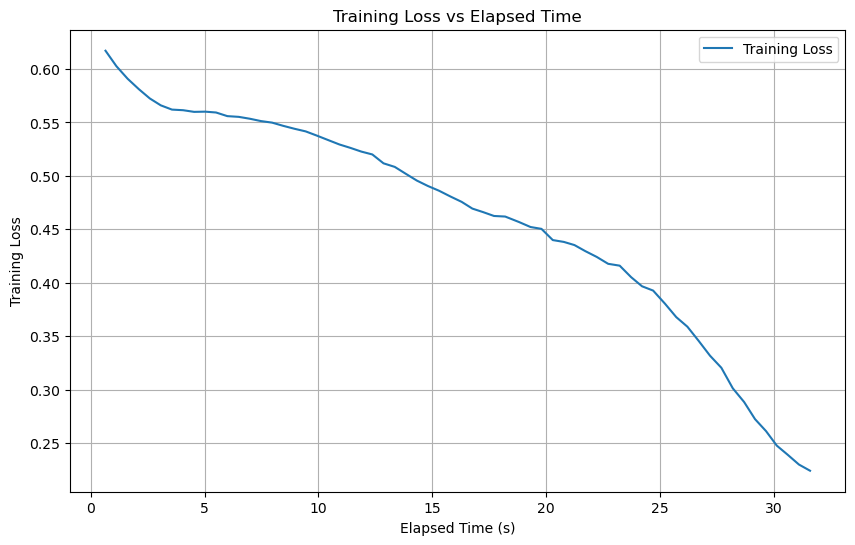

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
import os
import numpy as np
import pandas as pd
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

data_dir = '/home/jovyan/RnD/dataset_npy/dataset_csf' #provide input directory of the filtered data

# Hyperparameters
batch_size = 128
num_epochs = 64
learning_rate = 0.0001
step_size = 20  
gamma = 0.7  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset and DataLoader
train_dataset = PointCloudDataset(data_dir=data_dir, augment=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

val_dataset = PointCloudDataset(data_dir=data_dir, augment=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# Model
model = PointNetPlusPlus().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
epoch_durations = []
train_losses = []
start_time = time.time()
# Training Loop
best_val_loss = float('inf')
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0

    for data, labels in tqdm(dataloader, desc="Training", leave=False):
        data = data.to(device).float()
        labels = labels.to(device).float()  # BCEWithLogitsLoss expects float

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * data.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss


def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, labels in tqdm(dataloader, desc="Validation", leave=False):
            data = data.to(device).float()
            labels = labels.to(device).float()

            outputs = model(data)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * data.size(0)

            # Compute accuracy (using threshold of 0.5 for BCE)
            preds = torch.sigmoid(outputs) > 0.5
            correct += (preds == labels.bool()).sum().item()
            total += labels.numel()

    epoch_loss = running_loss / len(dataloader.dataset)
    accuracy = correct / total if total > 0 else 0
    return epoch_loss, accuracy
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    
    
    epoch_start_time = time.time()
    
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_accuracy = validate(model, val_loader, criterion, device)
    
    
    epoch_duration = time.time() - epoch_start_time
    epoch_durations.append(epoch_duration)
    train_losses.append(train_loss)
    
   
    scheduler.step()
    
    print(f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')
    
    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'edgesegment_pointnet_model.pth')
        print('Saved the best model!')

print('Training finished!')


elapsed_times = [sum(epoch_durations[:i+1]) for i in range(num_epochs)] 
df = pd.DataFrame({
    'Elapsed Time (s)': elapsed_times,
    'Train Loss': train_losses
})
df.to_csv('training_time_vs_loss.csv', index=False)

# Plot Training Loss vs Elapsed Time
plt.figure(figsize=(10, 6))
plt.plot(elapsed_times, train_losses, label='Training Loss')
plt.xlabel('Elapsed Time (s)')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Elapsed Time')
plt.legend()
plt.grid(True)
plt.savefig('training_loss_vs_time.png')
plt.show()


In [19]:
import torch
import numpy as np
from torch.utils.data import DataLoader


model.load_state_dict(torch.load('edgesegment_pointnet_model.pth', map_location=device))
model.to(device)
model.eval()  

# Load the test data
test_file = '/home/jovyan/RnD/dataset/grids_2.5/npy/cell_2_28.npy' #provide appropriate test data location
test_data = np.load(test_file)
test_points = torch.tensor(test_data[:, :3], dtype=torch.float32) 
test_labels = torch.tensor(test_data[:, 3], dtype=torch.float32) 

# Prepare test data loader
test_dataset = torch.utils.data.TensorDataset(test_points, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Testing function
def test_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for points, labels in test_loader:
            points, labels = points.to(device), labels.to(device)
            
            outputs = model(points)
            outputs = outputs.squeeze(-1)  # Shape: [batch_size, num_points]
            
            predicted = torch.round(torch.sigmoid(outputs))  # Apply sigmoid and round to get [0, 1]
            correct += (predicted == labels).sum().item()
            total += labels.numel()
    
    accuracy = correct / total
    return accuracy

# Test the model
test_accuracy = test_model(model, test_loader, device)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


# dlrv_project_ws/test_pico_2024-07-04_215824.npy

Test Accuracy: 11.77%


Model output shape: torch.Size([1, 4096])


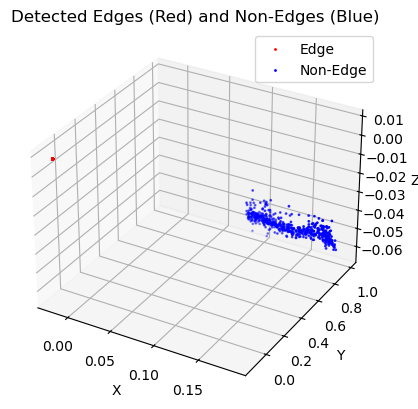

In [20]:
# Function to plot the point cloud with predicted edge and non-edge points
def plot_point_cloud_with_predictions(points, predictions):
    

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')


    if isinstance(predictions, torch.Tensor):
        predictions = predictions.cpu().numpy()


    if predictions.ndim == 1:
        predictions = predictions.reshape(-1)


    edges = points[predictions == 1]
    non_edges = points[predictions == 0]


    ax.scatter(edges[:, 0], edges[:, 1], edges[:, 2], c='r', label='Edge', s=1)


    ax.scatter(non_edges[:, 0], non_edges[:, 1], non_edges[:, 2], c='b', label='Non-Edge', s=1)


    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.legend()
    plt.title("Detected Edges (Red) and Non-Edges (Blue)")
    

    plt.show()

# provide Test point cloud file path
test_file = '/home/jovyan/RnD/dataset/grids_2.5/npy/cell_2_28.npy'

# Load the test point cloud
data = np.load(test_file)
points = data[:, :3] 


points = normalize_point_cloud(points)


points_tensor = torch.FloatTensor(points).unsqueeze(0).to(device) 

model = PointNetPlusPlus().to(device)
model.load_state_dict(torch.load('edgesegment_pointnet_model.pth')) #load the model using correct path
with torch.no_grad():
    outputs = model(points_tensor)
    print(f"Model output shape: {outputs.shape}")
    

    if outputs.ndimension() == 3:  
        outputs = outputs.squeeze(-1)  

    predictions = torch.round(torch.sigmoid(outputs)).squeeze()  # [num_points]


if predictions.ndimension() == 1:
    predictions = predictions.cpu().numpy()
else:
    predictions = predictions.squeeze().cpu().numpy()


# Plot the point cloud with predicted edges and non-edges
plot_point_cloud_with_predictions(points, predictions)


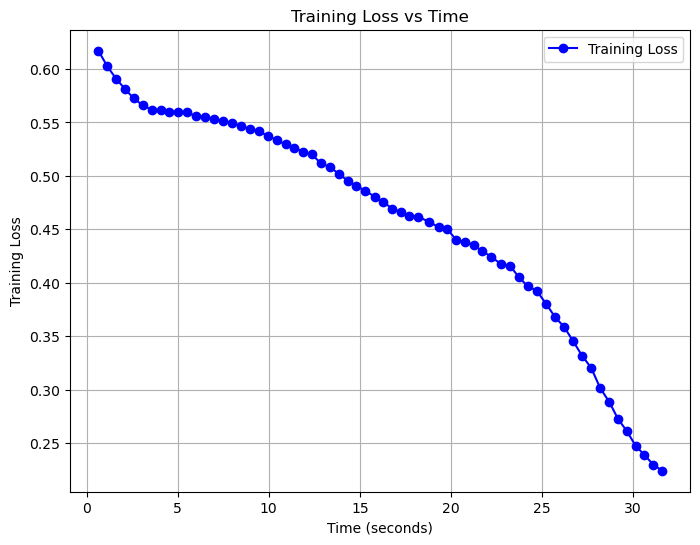

In [21]:

file_path= r'/home/jovyan/RnD/training_time_vs_loss.csv' #provide the correct filepath for the same
data = pd.read_csv(file_path)

# Plot training loss vs time
plt.figure(figsize=(8, 6))
plt.plot(data['Elapsed Time (s)'], data['Train Loss'], label='Training Loss', color='blue', marker='o')
plt.xlabel('Time (seconds)')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Time')
plt.legend()
plt.grid(True)
plt.show()